### Libraries and imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import os, glob
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
from itertools import combinations

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


These are the lists that declared used globally and describe the attributes we are using.
- **player_columns** is used to filter out the required attributes
- **player_averages**  is used to used to obtain the mentality metrics which are averaged across each country.
- **countries** is used to filter out the countries data which we are used to make the training data

In [2]:
player_columns = ['short_name',
                  'overall',
                  'age',
                  'club_name',
                  'nationality_name',
                  'mentality_aggression',
                  'mentality_interceptions',
                  'mentality_positioning',
                  'mentality_vision',
                  'mentality_penalties']


player_averages = ['overall', 
                   'age', 
                   'mentality_aggression', 
                   'mentality_interceptions',
                   'mentality_positioning', 
                   'mentality_vision', 
                   'mentality_penalties']



countries= ['Netherlands','Senegal','Ecuador',
            'England','United States','Iran','Wales',
            'Argentina','Poland','Mexico','Saudi Arabia',
            'France','Australia','Tunisia','Denmark',
            'Japan','Spain','Germany','Costa Rica',
            'Morocco','Croatia','Belgium','Canada',
            'Brazil','Switzerland','Cameroon','Serbia',
            'Portugal','Uruguay','Ghana',
            'Italy','Colombia','Sweden',
            'Peru','Chile','Ukraine','Austria',
            'Algeria','Czech Republic','Nigeria','Paraguay']


This matches dataframe consists of all the football matches that took place among all the countries in the last 150 years. This is obtained from kaggle.

We use above **countries** list to further filter only the countries that we are modeling for.


In [3]:
matches = pd.read_csv('data/matches.csv')
matches = matches.drop(['tournament', 'city', 'country', 'neutral'], axis = 1)

In [4]:
matches

,date,home_team,away_team,home_score,away_score
0,1872-11-30,Scotland,England,0,0
1,1873-03-08,England,Scotland,4,2
2,1874-03-07,Scotland,England,2,1
3,1875-03-06,England,Scotland,2,2
4,1876-03-04,Scotland,England,3,0
...,...,...,...,...,...
43416,2022-03-30,Mexico,El Salvador,2,0
43417,2022-03-30,Costa Rica,United States,2,0
43418,2022-03-30,Panama,Canada,1,0
43419,2022-03-30,Jamaica,Honduras,2,1


In [5]:
matches.describe()

,home_score,away_score
count,43421.000000,43421.000000
mean,1.741876,1.180972
std,1.751876,1.397932
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,31.000000,21.000000


Players CSV file consists of all the player details and metrics for each year. This is obtained from kaggle.

We use above lists to further filter down for the desired country Players.

Players dataset by year describes player details such as

- Player attributes
    - overall
    - age
    - mentality_aggression
    - mentality_interceptions
    - mentality_positioning
    - mentality_vision
    - mentality_penalties

In [6]:
df15 = pd.read_csv("data/players_15.csv") [player_columns]
df16 = pd.read_csv("data/players_16.csv") [player_columns]
df17 = pd.read_csv("data/players_17.csv") [player_columns]
df18 = pd.read_csv("data/players_18.csv", low_memory = False) [player_columns]
df19 = pd.read_csv("data/players_19.csv") [player_columns]
df20 = pd.read_csv("data/players_20.csv") [player_columns]
df21 = pd.read_csv("data/players_21.csv") [player_columns]
df22 = pd.read_csv("data/players_22_new.csv", low_memory=False) [player_columns]


In [7]:
df16

,short_name,overall,age,club_name,nationality_name,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties
0,E. Hysaj,75,21,Napoli,Albania,79,73,57,43,40
1,S. Gashi,74,26,FC Basel 1893,Albania,84,53,85,77,71
2,B. Berisha,73,29,Melbourne Victory,Albania,90,42,78,69,73
3,M. Mavraj,73,29,1. FC Köln,Albania,74,59,20,49,51
4,E. Berisha,73,26,Lazio,Albania,30,22,12,42,22
...,...,...,...,...,...,...,...,...,...,...
15618,M. Bonne,59,19,Colchester United,Zimbabwe,46,14,52,33,51
15619,R. Pfumbidzai,58,20,Hobro IK,Zimbabwe,61,53,45,35,36
15620,D. Gwaze,55,26,Górnik Zabrze,Zimbabwe,33,36,57,41,52
15621,T. Kadewere,54,19,Djurgårdens IF,Zimbabwe,44,12,52,45,44


### Here we group by  nationality and obtain the top 23 palyers as each team in worldcup is allowed to travel with 23  players squad.

### Each of the players in a country are sorted according to their overall scores which indicates the probaility of that player getting into the playing team.

In [8]:
df15 = df15.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df16 = df16.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df17 = df17.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df18 = df18.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df19 = df19.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df20 = df20.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df21 = df21.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)
df22 = df22.sort_values(['nationality_name','overall'], ascending=False).groupby('nationality_name').head(23)

In [9]:
df15.head(25)

,short_name,overall,age,club_name,nationality_name,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties
16143,K. Musona,70,24,TSG Hoffenheim,Zimbabwe,48,24,70,62,72
16144,K. Nkhatha,68,28,Kaizer Chiefs,Zimbabwe,62,38,61,50,68
16145,Q. Antipas,67,30,Hobro IK,Zimbabwe,69,37,72,56,63
16146,W. Katsande,65,28,Kaizer Chiefs,Zimbabwe,76,69,53,51,46
16147,M. Rusike,65,24,Kaizer Chiefs,Zimbabwe,44,25,66,65,51
16148,O. Karuru,63,25,Kaizer Chiefs,Zimbabwe,56,55,61,58,52
16149,B. Pritchard,63,28,Leyton Orient,Zimbabwe,55,63,63,65,55
16150,D. Gwaze,61,25,Górnik Zabrze,Zimbabwe,32,35,56,40,51
16151,M. Bonne,56,18,Colchester United,Zimbabwe,45,25,51,32,50
16152,S. Songani,56,25,SønderjyskE,Zimbabwe,34,26,45,45,45


Here we are using the above countries list to filter out the required players who are playing the worldcup.

In [10]:
df15 = df15[df15.nationality_name.isin(countries)]
df15.nationality_name.value_counts()

df16 = df16[df16.nationality_name.isin(countries)]
df16.nationality_name.value_counts()

df17 = df17[df17.nationality_name.isin(countries)]
df17.nationality_name.value_counts()

df18 = df18[df18.nationality_name.isin(countries)]
df18.nationality_name.value_counts()

df19 = df19[df19.nationality_name.isin(countries)]
df19.nationality_name.value_counts()

df20 = df20[df20.nationality_name.isin(countries)]
df20.nationality_name.value_counts()

df21 = df21[df21.nationality_name.isin(countries)]
df21.nationality_name.value_counts()

df22 = df22[df22.nationality_name.isin(countries)]
df22.nationality_name.value_counts()

df22.nationality_name.value_counts()

Denmark           23
Portugal          23
Wales             23
Switzerland       23
Netherlands       23
Canada            23
France            23
Japan             23
Costa Rica        23
Austria           23
Algeria           23
Czech Republic    23
Paraguay          23
Colombia          23
Saudi Arabia      23
Chile             23
Senegal           23
Croatia           23
Australia         23
Tunisia           23
Mexico            23
Sweden            23
Ghana             23
Morocco           23
Serbia            23
Belgium           23
Ecuador           23
Cameroon          23
Spain             23
England           23
Peru              23
Italy             23
United States     23
Germany           23
Brazil            23
Poland            23
Nigeria           23
Uruguay           23
Argentina         23
Ukraine           23
Iran              21
Name: nationality_name, dtype: int64

We are calculating the mean of the required player metrics across each nation for a year as shown below:

In [11]:
national_mentalities_2015 = df15.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2015['year'] = 2015
national_mentalities_2015

national_mentalities_2016 = df16.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2016['year'] = 2016
national_mentalities_2016

national_mentalities_2017 = df17.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2017['year'] = 2017
national_mentalities_2017

national_mentalities_2018 = df18.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2018['year'] = 2018
national_mentalities_2018

national_mentalities_2019 = df19.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2019['year'] = 2019
national_mentalities_2019

national_mentalities_2020 = df20.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2020['year'] = 2020
national_mentalities_2020

national_mentalities_2021 = df21.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2021['year'] = 2021
national_mentalities_2021

national_mentalities_2022 = df22.groupby('nationality_name')[player_averages].mean().reset_index()
national_mentalities_2022['year'] = 2022
national_mentalities_2022


,nationality_name,overall,age,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,year
0,Algeria,76.304348,28.391304,65.304348,46.739130,66.782609,71.086957,61.913043,2022
1,Argentina,83.304348,28.913043,66.565217,50.260870,70.173913,75.695652,62.304348,2022
2,Australia,71.913043,28.869565,63.304348,54.130435,54.130435,62.434783,53.521739,2022
3,Austria,77.652174,28.173913,68.086957,62.782609,62.565217,67.173913,55.391304,2022
4,Belgium,82.043478,29.391304,61.826087,55.869565,62.391304,70.000000,58.521739,2022
5,Brazil,84.434783,29.391304,71.304348,63.217391,64.913043,73.652174,62.739130,2022
6,Cameroon,74.739130,27.565217,68.565217,52.478261,68.000000,63.695652,59.782609,2022
7,Canada,71.869565,26.826087,61.652174,50.304348,55.304348,61.347826,49.956522,2022
8,Chile,75.478261,31.130435,68.130435,59.173913,60.391304,66.130435,58.217391,2022
9,Colombia,78.608696,29.478261,68.913043,50.913043,65.217391,66.739130,60.826087,2022


An average player plays two world cups i.e. 8 years for their national team.

So we are filtering out the match data that is required (in this case data from 2015 to 2022)

In [12]:
matches_2015 = matches.loc[(matches.date>'2015') & (matches.date<'2016')]
matches_2015['year']=2015

matches_2016 = matches.loc[(matches.date>'2016') & (matches.date<'2017')]
matches_2016['year']=2016

matches_2017 = matches.loc[(matches.date>'2017') & (matches.date<'2018')]
matches_2017['year']=2017

matches_2018 = matches.loc[(matches.date>'2018') & (matches.date<'2019')]
matches_2018['year']=2018

matches_2019 = matches.loc[(matches.date>'2019') & (matches.date<'2020')]
matches_2019['year']=2019

matches_2020 = matches.loc[(matches.date>'2020') & (matches.date<'2021')]
matches_2020['year']=2020

matches_2021 = matches.loc[(matches.date>'2021') & (matches.date<'2022')]
matches_2021['year']=2021

In [13]:
matches_2021

,date,home_team,away_team,home_score,away_score,year
42063,2021-01-12,United Arab Emirates,Iraq,0,0,2021
42064,2021-01-18,Kuwait,Palestine,0,1,2021
42065,2021-01-19,Dominican Republic,Puerto Rico,0,1,2021
42066,2021-01-22,Guatemala,Puerto Rico,1,0,2021
42067,2021-01-25,Dominican Republic,Serbia,0,0,2021
...,...,...,...,...,...,...
43144,2021-12-18,Tunisia,Algeria,0,2,2021
43145,2021-12-18,United States,Bosnia and Herzegovina,1,0,2021
43146,2021-12-30,Mauritania,Burkina Faso,0,0,2021
43147,2021-12-30,Sudan,Ethiopia,2,3,2021


From the matches data sets we are making sure that home team column and away team column consists of all the nations that are going to play the worldcup

In [14]:
matches_2015_wc = matches_2015[(matches_2015['home_team'].isin(countries)) & (matches_2015['away_team'].isin(countries))]
matches_2016_wc = matches_2016[(matches_2016['home_team'].isin(countries)) & (matches_2016['away_team'].isin(countries))]
matches_2017_wc = matches_2017[(matches_2017['home_team'].isin(countries)) & (matches_2017['away_team'].isin(countries))]
matches_2018_wc = matches_2018[(matches_2018['home_team'].isin(countries)) & (matches_2018['away_team'].isin(countries))]
matches_2019_wc = matches_2019[(matches_2019['home_team'].isin(countries)) & (matches_2019['away_team'].isin(countries))]
matches_2020_wc = matches_2020[(matches_2020['home_team'].isin(countries)) & (matches_2020['away_team'].isin(countries))]
matches_2021_wc = matches_2021[(matches_2021['home_team'].isin(countries)) & (matches_2021['away_team'].isin(countries))]

In [15]:
matches_2021_wc 

,date,home_team,away_team,home_score,away_score,year
42090,2021-03-24,France,Ukraine,1,1,2021
42092,2021-03-24,Belgium,Wales,3,1,2021
42151,2021-03-27,Wales,Mexico,1,0,2021
42159,2021-03-27,Serbia,Portugal,2,2,2021
42161,2021-03-27,Czech Republic,Belgium,1,1,2021
...,...,...,...,...,...,...
43106,2021-11-16,Chile,Ecuador,0,2,2021
43131,2021-12-07,Morocco,Saudi Arabia,1,0,2021
43134,2021-12-08,Mexico,Chile,2,2,2021
43139,2021-12-11,Morocco,Algeria,2,2,2021


### Generate classes for training on the above data

To generate the binary classes required for training a predictive model, we do the following.

- First we consider the difference of Home score and Away score.
- When the home team wins we catagorize it as Class 1(team1)
- When the away team wins we catagorize it as Class 2(team2)

In [16]:
for df in [matches_2015_wc, matches_2016_wc, matches_2017_wc, \
           matches_2018_wc, matches_2019_wc, matches_2020_wc, matches_2021_wc]:
    
    # take the difference of home and away score
    df['score'] = df.home_score - df.away_score
    
    # create a empty column to hold the results
    df['result'] = None
    df['result'][df.score > 0] = 1
    df['result'][df.score < 0] = 2
    df['result'][df.score == 0] = 0
    

In [17]:
matches_2021_wc

,date,home_team,away_team,home_score,away_score,year,score,result
42090,2021-03-24,France,Ukraine,1,1,2021,0,0
42092,2021-03-24,Belgium,Wales,3,1,2021,2,1
42151,2021-03-27,Wales,Mexico,1,0,2021,1,1
42159,2021-03-27,Serbia,Portugal,2,2,2021,0,0
42161,2021-03-27,Czech Republic,Belgium,1,1,2021,0,0
...,...,...,...,...,...,...,...,...
43106,2021-11-16,Chile,Ecuador,0,2,2021,-2,2
43131,2021-12-07,Morocco,Saudi Arabia,1,0,2021,1,1
43134,2021-12-08,Mexico,Chile,2,2,2021,0,0
43139,2021-12-11,Morocco,Algeria,2,2,2021,0,0


### Web scraping for data augmentation

To obtain the official country rating for each country over the years, we scrape the [Fifa index](https://www.fifaindex.com/) website. 

We use Beautiful soup and  python to scrape the data. 

We identify required columns using html "data-title" tag and construct the data frame for exporting. 

Below is the code used for crawling. This can also be found in **crawler.py**

```python

countries = []
for year in url_dict:

	page1 = url_dict[year]
	page2 = page1.split('?')[0] + '?page=2&' + page1.split('?')[1] 
	pages = [page1, page2]

	for page in pages:
		
		try:
			soup = get_soup(page)

			for s in soup.findAll("td", attrs={"data-title": "Name"}):				

				att = s.find_next('td').find_next('td')
				mid = att.find_next('td')
				dif = mid.find_next('td')
				ovr = dif.find_next('td')

				df2 = {'country': s.text,
						'year': year,
						'att': att.text,
						'mid': mid.text,
						'def': dif.text,
						'ovr': ovr.text
						}

				df = df.append(df2, ignore_index = True)

		except:
			print("page not found", page)

df.to_csv('country_rating.csv')

```


The country_rating dataframe contains teams attributes for each year.

- **att** : rating for team's attacking nature.
- **mid** : rating to understand how strong a team's midfield is.
- **def** : rating to understand how strong a team's defence is.
- **ovr** : overall teams performance metrics.

In [18]:
country_ratings = pd.read_csv('data/country_rating.csv')

country_ratings = country_ratings.drop('Unnamed: 0', axis =1)
country_ratings


,country,att,mid,def,ovr,year
0,Argentina,86,85,87,85,2005
1,Argentina,87,81,85,83,2006
2,Argentina,87,80,79,83,2007
3,Argentina,85,80,80,83,2008
4,Argentina,87,84,82,84,2009
...,...,...,...,...,...,...
826,Wales,82,71,77,74,2018
827,Wales,77,74,73,74,2019
828,Wales,70,76,72,74,2020
829,Wales,77,74,72,74,2021


### Obtaining the final data frame for training 

- We first merge the  matches dataframe with country ratings data frame based on natinality and year

- Next, we merge the national_metalities dataframe to the above generated data frame based again on nationality and year to finally obtain the training data.

In [19]:
matches_2015_wc = matches_2015_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2015_wc = matches_2015_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2015 = matches_2015_wc.merge(national_mentalities_2015,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
merged_2015 = merged_2015.merge(national_mentalities_2015,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [20]:
matches_2016_wc = matches_2016_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2016_wc = matches_2016_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2016 = matches_2016_wc.merge(national_mentalities_2016,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
merged_2016 = merged_2016.merge(national_mentalities_2016,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [21]:
matches_2017_wc = matches_2017_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2017_wc = matches_2017_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2017 = matches_2017_wc.merge(national_mentalities_2017,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
merged_2017 = merged_2017.merge(national_mentalities_2017,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [22]:
matches_2018_wc = matches_2018_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2018_wc = matches_2018_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2018 = matches_2018_wc.merge(national_mentalities_2018,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
merged_2018 = merged_2018.merge(national_mentalities_2018,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))


In [23]:
matches_2019_wc = matches_2019_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2019_wc = matches_2019_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'],
                                      suffixes=('_1','_2'))
merged_2019 = matches_2019_wc.merge(national_mentalities_2019,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
                                      
merged_2019 = merged_2019.merge(national_mentalities_2019,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [24]:
matches_2020_wc = matches_2020_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2020_wc = matches_2020_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2020 = matches_2020_wc.merge(national_mentalities_2020,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])

merged_2020 = merged_2020.merge(national_mentalities_2020,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [25]:
matches_2021_wc = matches_2021_wc.merge(country_ratings,how='left', 
                                      left_on=['home_team', 'year'], 
                                      right_on=['country', 'year'])
matches_2021_wc = matches_2021_wc.merge(country_ratings,how='left', 
                                      left_on=['away_team', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
merged_2021 = matches_2021_wc.merge(national_mentalities_2021,how='left', 
                                   left_on=['home_team', 'year'], 
                                   right_on=['nationality_name', 'year'])
merged_2021 = merged_2021.merge(national_mentalities_2021,how='left', 
                              left_on=['away_team', 'year'], 
                              right_on=['nationality_name', 'year'],  
                              suffixes=('_1','_2'))

In [26]:
merged_2015

,date,home_team,away_team,home_score,away_score,year,score,result,country_1,att_1,mid_1,def_1,ovr_1,country_2,att_2,mid_2,def_2,ovr_2,nationality_name_1,overall_1,age_1,mentality_aggression_1,mentality_interceptions_1,mentality_positioning_1,mentality_vision_1,mentality_penalties_1,nationality_name_2,overall_2,age_2,mentality_aggression_2,mentality_interceptions_2,mentality_positioning_2,mentality_vision_2,mentality_penalties_2
0,2015-01-11,Tunisia,Algeria,1,1,2015,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tunisia,66.913043,25.695652,61.913043,50.739130,55.565217,58.608696,54.043478,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
1,2015-01-19,Ghana,Senegal,1,2,2015,-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ghana,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,Senegal,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435
2,2015-01-23,Ghana,Algeria,1,0,2015,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ghana,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
3,2015-01-27,Senegal,Algeria,0,2,2015,-2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senegal,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
4,2015-01-28,Chile,United States,3,2,2015,1,1,Chile,76.0,76.0,73.0,76.0,United States,76.0,70.0,72.0,73.0,Chile,76.130435,28.478261,64.434783,48.043478,63.608696,65.217391,64.304348,United States,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2015-11-17,Colombia,Argentina,0,1,2015,-1,2,Colombia,81.0,78.0,75.0,78.0,Argentina,86.0,80.0,81.0,82.0,Colombia,77.608696,26.391304,64.086957,52.260870,62.304348,63.217391,62.956522,Argentina,81.782609,27.913043,71.130435,60.304348,65.347826,70.000000,65.782609
88,2015-11-17,Denmark,Sweden,2,2,2015,0,0,Denmark,75.0,72.0,74.0,74.0,Sweden,80.0,75.0,72.0,74.0,Denmark,74.739130,26.956522,62.347826,57.304348,55.869565,56.913043,54.130435,Sweden,75.304348,28.913043,68.260870,56.130435,64.217391,64.304348,59.652174
89,2015-11-17,England,France,2,0,2015,2,1,England,81.0,78.0,78.0,80.0,France,80.0,80.0,80.0,81.0,England,80.478261,28.869565,70.391304,62.304348,62.478261,66.130435,65.173913,France,81.956522,27.260870,66.086957,61.695652,56.260870,61.000000,55.478261
90,2015-11-17,Poland,Czech Republic,3,1,2015,2,1,Poland,78.0,72.0,74.0,75.0,Czech Republic,73.0,73.0,72.0,74.0,Poland,75.434783,27.434783,63.260870,53.130435,58.000000,58.304348,58.043478,Czech Republic,74.173913,27.304348,63.695652,54.304348,57.826087,58.956522,60.478261


Now that we genrated data frame based on years we concatinate the dataframes to form the merged dataframe.

In [27]:

merged = [merged_2015, merged_2016, merged_2017, merged_2018, merged_2019, merged_2020, merged_2021]


df_merged = pd.concat(merged, ignore_index=False)
df_merged = df_merged.reset_index()


In [28]:
df_merged

,index,date,home_team,away_team,home_score,away_score,year,score,result,country_1,att_1,mid_1,def_1,ovr_1,country_2,att_2,mid_2,def_2,ovr_2,nationality_name_1,overall_1,age_1,mentality_aggression_1,mentality_interceptions_1,mentality_positioning_1,mentality_vision_1,mentality_penalties_1,nationality_name_2,overall_2,age_2,mentality_aggression_2,mentality_interceptions_2,mentality_positioning_2,mentality_vision_2,mentality_penalties_2
0,0,2015-01-11,Tunisia,Algeria,1,1,2015,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tunisia,66.913043,25.695652,61.913043,50.739130,55.565217,58.608696,54.043478,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
1,1,2015-01-19,Ghana,Senegal,1,2,2015,-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ghana,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,Senegal,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435
2,2,2015-01-23,Ghana,Algeria,1,0,2015,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ghana,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
3,3,2015-01-27,Senegal,Algeria,0,2,2015,-2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senegal,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435,Algeria,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
4,4,2015-01-28,Chile,United States,3,2,2015,1,1,Chile,76.0,76.0,73.0,76.0,United States,76.0,70.0,72.0,73.0,Chile,76.130435,28.478261,64.434783,48.043478,63.608696,65.217391,64.304348,United States,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,135,2021-11-16,Chile,Ecuador,0,2,2021,-2,2,Chile,74.0,76.0,73.0,75.0,Ecuador,74.0,72.0,75.0,73.0,Chile,76.347826,30.000000,69.565217,60.782609,62.565217,66.217391,58.869565,Ecuador,74.521739,30.826087,63.608696,48.434783,56.478261,56.956522,53.826087
765,136,2021-12-07,Morocco,Saudi Arabia,1,0,2021,1,1,Morocco,74.0,77.0,77.0,76.0,NaN,NaN,NaN,NaN,NaN,Morocco,77.173913,28.260870,66.173913,52.260870,66.782609,70.217391,60.826087,Saudi Arabia,69.434783,28.608696,57.565217,50.478261,52.478261,57.956522,50.217391
766,137,2021-12-08,Mexico,Chile,2,2,2021,0,0,Mexico,78.0,76.0,75.0,76.0,Chile,74.0,76.0,73.0,75.0,Mexico,77.782609,28.086957,61.565217,56.782609,67.565217,71.521739,63.086957,Chile,76.347826,30.000000,69.565217,60.782609,62.565217,66.217391,58.869565
767,138,2021-12-11,Morocco,Algeria,2,2,2021,0,0,Morocco,74.0,77.0,77.0,76.0,NaN,NaN,NaN,NaN,NaN,Morocco,77.173913,28.260870,66.173913,52.260870,66.782609,70.217391,60.826087,Algeria,76.173913,27.086957,67.478261,50.391304,68.869565,71.043478,64.434783


Checking for missing values in mentalitites.

In [29]:
df_check_mentalities_nans_1 = df_merged[['overall_1', 'age_1', 'mentality_aggression_1', 'mentality_interceptions_1', 
                                       'mentality_positioning_1', 'mentality_vision_1', 'mentality_penalties_1']].isnull()

print(df_check_mentalities_nans_1.any())


df_check_mentalities_nans_2 = df_merged[['overall_2', 'age_2', 'mentality_aggression_2', 'mentality_interceptions_2', 
                                       'mentality_positioning_2', 'mentality_vision_2', 'mentality_penalties_2']].isnull()

print(df_check_mentalities_nans_2.any())

overall_1                    False
age_1                        False
mentality_aggression_1       False
mentality_interceptions_1    False
mentality_positioning_1      False
mentality_vision_1           False
mentality_penalties_1        False
dtype: bool
overall_2                    False
age_2                        False
mentality_aggression_2       False
mentality_interceptions_2    False
mentality_positioning_2      False
mentality_vision_2           False
mentality_penalties_2        False
dtype: bool


No missing values in palyer mentalities

### Imputing missing country ratings

In [30]:
df_nans_1 = df_merged[(df_merged['country_1'].isnull())]
print(df_nans_1['home_team'].unique())

['Tunisia' 'Ghana' 'Senegal' 'Canada' 'Nigeria' 'Serbia' 'Ukraine'
 'Algeria' 'Iran' 'Saudi Arabia']


We can see that for above countries the country ratings are missing. 

Based on the rankings of these missing countries we realized that they are underperformers .

So, we consider 25th percentile of each column containing missing values and impute it with the 25th %ile value.

First, We drop the below unnecessary columns

In [31]:
drop_columns =['score','date','home_team','away_team','home_score','away_score','year','country_1','country_2','nationality_name_1','nationality_name_2']

In [32]:
df_merged = df_merged.drop(drop_columns,axis = 1)

In [33]:
def fillna(col):
    col.fillna(col.quantile(0.25), inplace=True)
    return col

df_merged = df_merged.apply(lambda col:fillna(col))


In [34]:
df_merged.isna().any()

index                        False
result                       False
att_1                        False
mid_1                        False
def_1                        False
ovr_1                        False
att_2                        False
mid_2                        False
def_2                        False
ovr_2                        False
overall_1                    False
age_1                        False
mentality_aggression_1       False
mentality_interceptions_1    False
mentality_positioning_1      False
mentality_vision_1           False
mentality_penalties_1        False
overall_2                    False
age_2                        False
mentality_aggression_2       False
mentality_interceptions_2    False
mentality_positioning_2      False
mentality_vision_2           False
mentality_penalties_2        False
dtype: bool

In [35]:
df_merged 

,index,result,att_1,mid_1,def_1,ovr_1,att_2,mid_2,def_2,ovr_2,overall_1,age_1,mentality_aggression_1,mentality_interceptions_1,mentality_positioning_1,mentality_vision_1,mentality_penalties_1,overall_2,age_2,mentality_aggression_2,mentality_interceptions_2,mentality_positioning_2,mentality_vision_2,mentality_penalties_2
0,0,0,75.75,75.0,74.0,75.0,74.0,74.0,73.0,74.0,66.913043,25.695652,61.913043,50.739130,55.565217,58.608696,54.043478,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
1,1,2,75.75,75.0,74.0,75.0,74.0,74.0,73.0,74.0,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435
2,2,1,75.75,75.0,74.0,75.0,74.0,74.0,73.0,74.0,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
3,3,2,75.75,75.0,74.0,75.0,74.0,74.0,73.0,74.0,75.217391,26.521739,71.565217,54.086957,63.565217,61.652174,60.130435,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
4,4,1,76.00,76.0,73.0,76.0,76.0,70.0,72.0,73.0,76.130435,28.478261,64.434783,48.043478,63.608696,65.217391,64.304348,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,135,2,74.00,76.0,73.0,75.0,74.0,72.0,75.0,73.0,76.347826,30.000000,69.565217,60.782609,62.565217,66.217391,58.869565,74.521739,30.826087,63.608696,48.434783,56.478261,56.956522,53.826087
765,136,1,74.00,77.0,77.0,76.0,74.0,74.0,73.0,74.0,77.173913,28.260870,66.173913,52.260870,66.782609,70.217391,60.826087,69.434783,28.608696,57.565217,50.478261,52.478261,57.956522,50.217391
766,137,0,78.00,76.0,75.0,76.0,74.0,76.0,73.0,75.0,77.782609,28.086957,61.565217,56.782609,67.565217,71.521739,63.086957,76.347826,30.000000,69.565217,60.782609,62.565217,66.217391,58.869565
767,138,0,74.00,77.0,77.0,76.0,74.0,74.0,73.0,74.0,77.173913,28.260870,66.173913,52.260870,66.782609,70.217391,60.826087,76.173913,27.086957,67.478261,50.391304,68.869565,71.043478,64.434783


Here we store these vaues  so that we can impute it in 2022 data frame.

In [36]:
att_imputed = df_merged['att_1'].quantile(0.25)
mid_imputed = df_merged['mid_1'].quantile(0.25)
def_imputed = df_merged['def_1'].quantile(0.25)
ovr_imputed = df_merged['ovr_1'].quantile(0.25)

<Figure size 2160x1440 with 0 Axes>

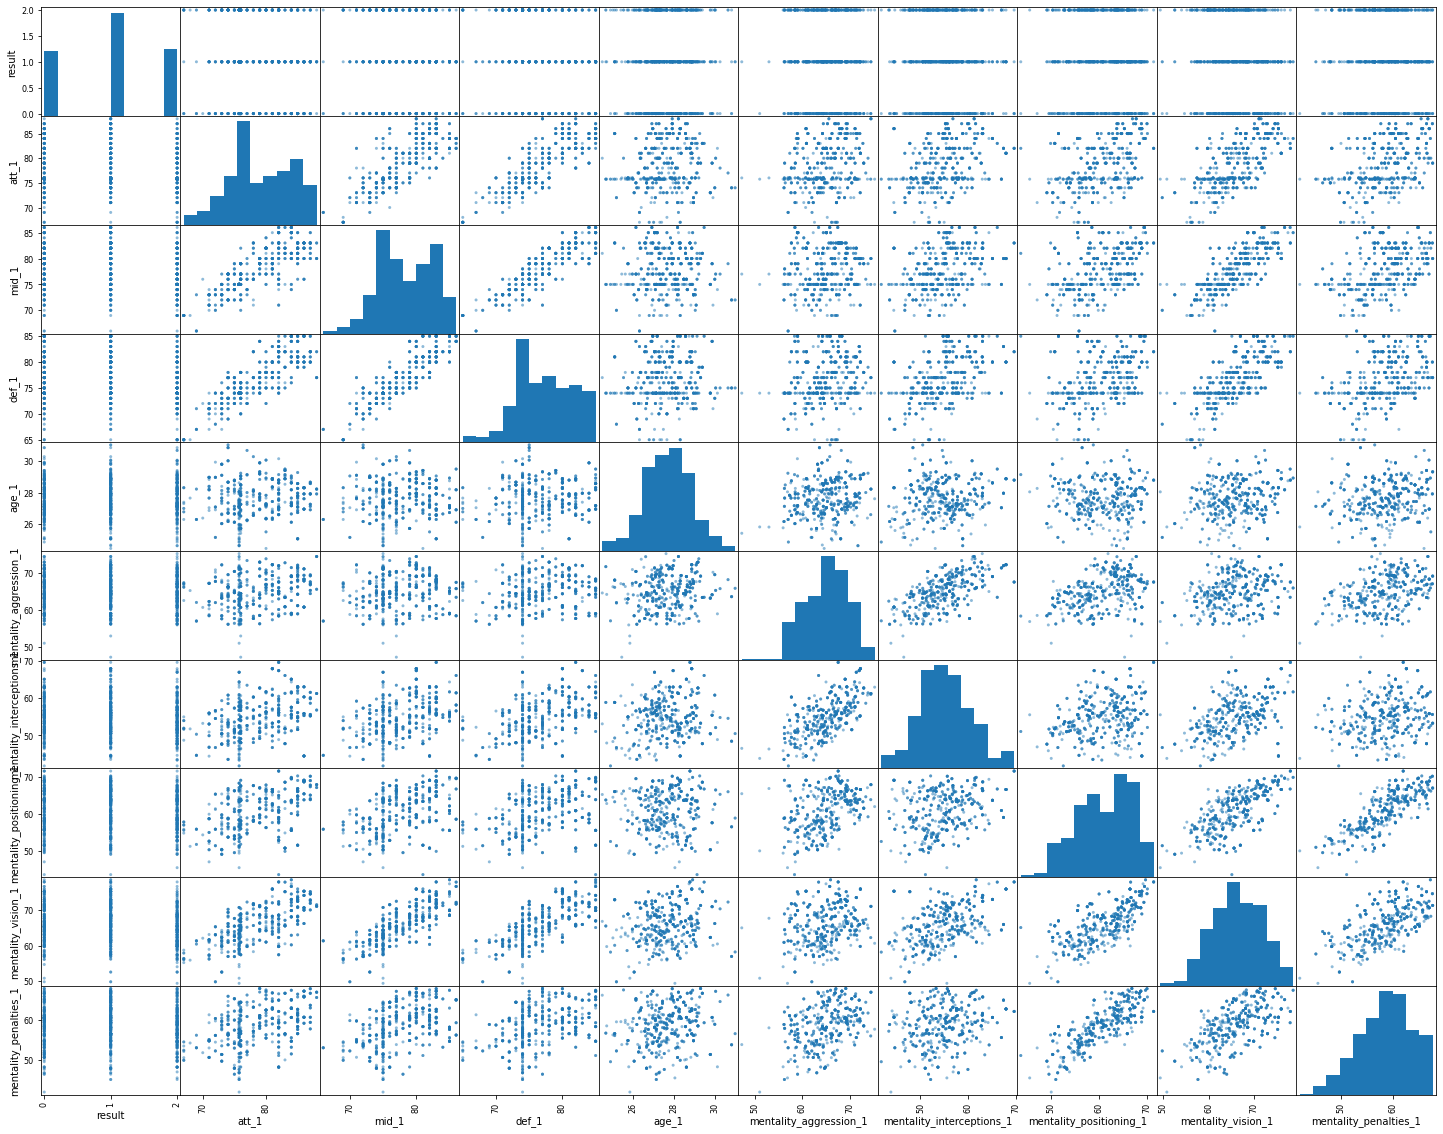

In [37]:
# selecting three numerical features
features = ['result','att_1','mid_1','def_1','age_1','mentality_aggression_1','mentality_interceptions_1','mentality_positioning_1','mentality_vision_1','mentality_penalties_1']

fig = plt.figure(figsize=(30,20))

# plotting the scatter matrix
# with the features
scatter_matrix(df_merged[features],figsize=(25,20))
plt.show()

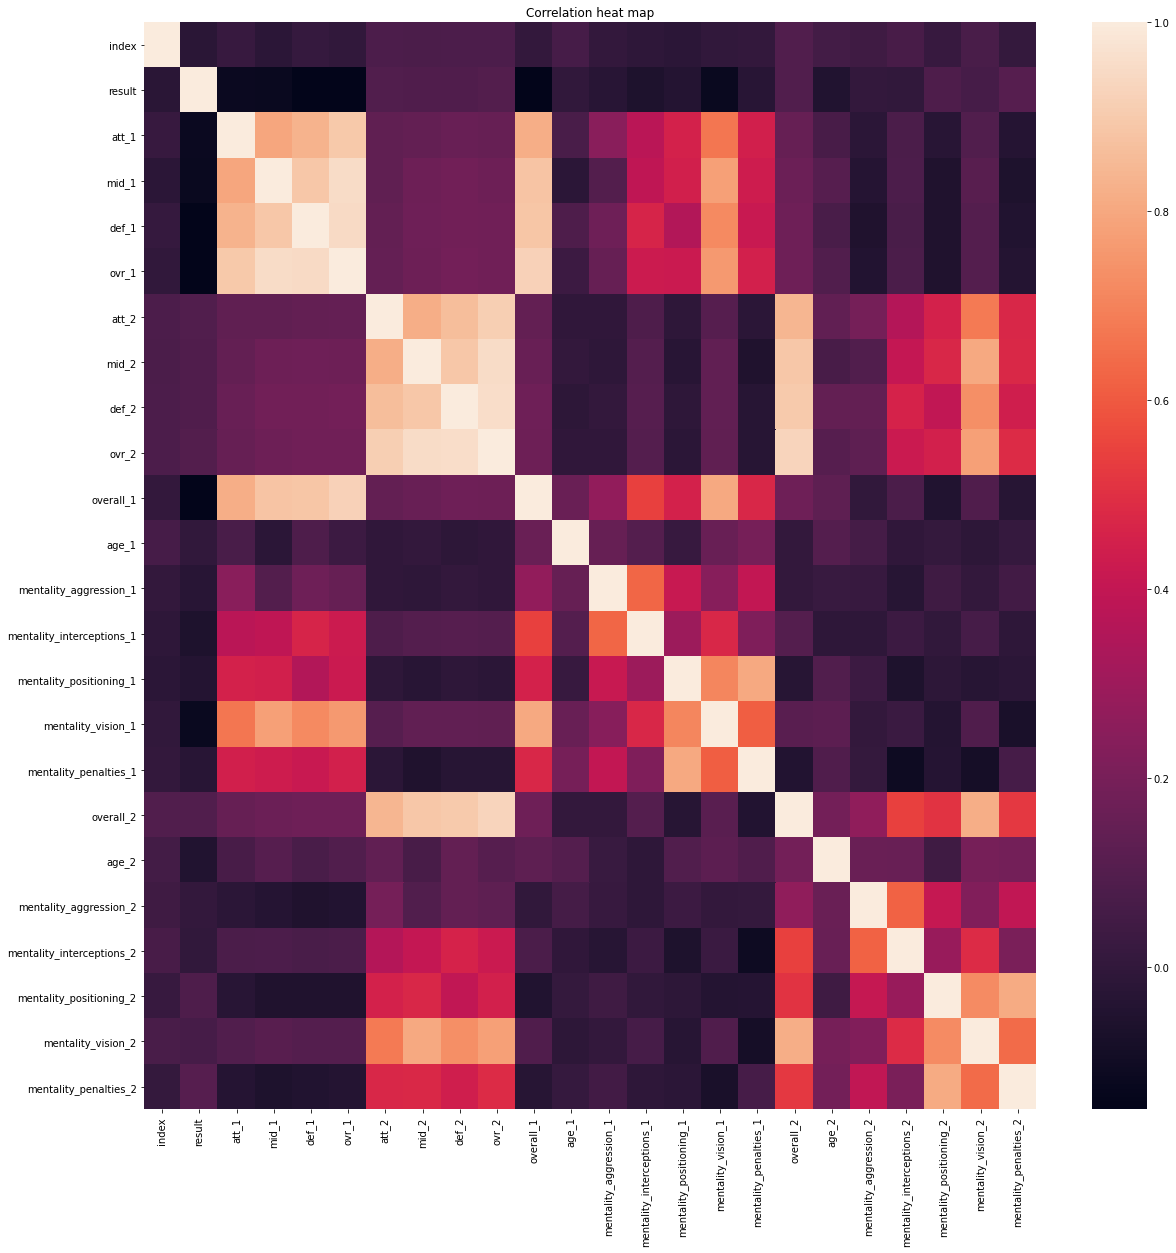

In [38]:
# calculate the correlation matrix
corr = df_merged.corr()

fig, ax = plt.subplots(figsize=(20, 20))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

plt.title("Correlation heat map")
plt.show()

In [39]:
cor_matrix = df_merged.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(highly_correlated)

                           index    result     att_1     mid_1     def_1  \
index                        NaN  0.020845  0.016979  0.019569  0.012310   
result                       NaN       NaN  0.116700  0.122271  0.145868   
att_1                        NaN       NaN       NaN  0.794991  0.831932   
mid_1                        NaN       NaN       NaN       NaN  0.889570   
def_1                        NaN       NaN       NaN       NaN       NaN   
ovr_1                        NaN       NaN       NaN       NaN       NaN   
att_2                        NaN       NaN       NaN       NaN       NaN   
mid_2                        NaN       NaN       NaN       NaN       NaN   
def_2                        NaN       NaN       NaN       NaN       NaN   
ovr_2                        NaN       NaN       NaN       NaN       NaN   
overall_1                    NaN       NaN       NaN       NaN       NaN   
age_1                        NaN       NaN       NaN       NaN       NaN   
mentality_ag

From the above figure, we can see high correlations between

- def_1 and ovr_1 & def_2 and ovr_2

Let's drop def_1 and def_2.


In [40]:
to_drop = ['def_1', 'def_2']

In [41]:
df_merged = df_merged.drop(to_drop, axis=1)

Below we obtain the  required data frame to simulate the 2022 worldcup matches  

In [42]:
len(df_merged)

769

In [43]:
national_mentalities_2022 = national_mentalities_2022.merge(country_ratings, how='left', 
                                      left_on=['nationality_name', 'year'], 
                                      right_on=['country', 'year'], 
                                      suffixes=('_1','_2'))
national_mentalities_2022



,nationality_name,overall,age,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,year,country,att,mid,def,ovr
0,Algeria,76.304348,28.391304,65.304348,46.739130,66.782609,71.086957,61.913043,2022,NaN,NaN,NaN,NaN,NaN
1,Argentina,83.304348,28.913043,66.565217,50.260870,70.173913,75.695652,62.304348,2022,Argentina,86.0,81.0,81.0,83.0
2,Australia,71.913043,28.869565,63.304348,54.130435,54.130435,62.434783,53.521739,2022,Australia,75.0,69.0,71.0,70.0
3,Austria,77.652174,28.173913,68.086957,62.782609,62.565217,67.173913,55.391304,2022,Austria,79.0,78.0,78.0,77.0
4,Belgium,82.043478,29.391304,61.826087,55.869565,62.391304,70.000000,58.521739,2022,Belgium,83.0,82.0,80.0,83.0
5,Brazil,84.434783,29.391304,71.304348,63.217391,64.913043,73.652174,62.739130,2022,Brazil,80.0,80.0,80.0,80.0
6,Cameroon,74.739130,27.565217,68.565217,52.478261,68.000000,63.695652,59.782609,2022,NaN,NaN,NaN,NaN,NaN
7,Canada,71.869565,26.826087,61.652174,50.304348,55.304348,61.347826,49.956522,2022,Canada,75.0,73.0,70.0,73.0
8,Chile,75.478261,31.130435,68.130435,59.173913,60.391304,66.130435,58.217391,2022,Chile,74.0,76.0,73.0,75.0
9,Colombia,78.608696,29.478261,68.913043,50.913043,65.217391,66.739130,60.826087,2022,Colombia,81.0,79.0,77.0,78.0


In [44]:
national_mentalities_2022['att'] = national_mentalities_2022['att'].fillna(value=att_imputed)
national_mentalities_2022['mid'] = national_mentalities_2022['mid'].fillna(value=mid_imputed)
national_mentalities_2022['def'] = national_mentalities_2022['def'].fillna(value=def_imputed)
national_mentalities_2022['ovr'] = national_mentalities_2022['ovr'].fillna(value=ovr_imputed)

In [45]:
drop_columns =['year','country']
simulate2022_modified = national_mentalities_2022.drop(drop_columns,axis = 1)

This  is the 2022 datafram ie used to simuate the 2022 worlcup matches

In [46]:
simulate2022_modified

,nationality_name,overall,age,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,att,mid,def,ovr
0,Algeria,76.304348,28.391304,65.304348,46.739130,66.782609,71.086957,61.913043,75.75,75.0,74.0,75.0
1,Argentina,83.304348,28.913043,66.565217,50.260870,70.173913,75.695652,62.304348,86.00,81.0,81.0,83.0
2,Australia,71.913043,28.869565,63.304348,54.130435,54.130435,62.434783,53.521739,75.00,69.0,71.0,70.0
3,Austria,77.652174,28.173913,68.086957,62.782609,62.565217,67.173913,55.391304,79.00,78.0,78.0,77.0
4,Belgium,82.043478,29.391304,61.826087,55.869565,62.391304,70.000000,58.521739,83.00,82.0,80.0,83.0
5,Brazil,84.434783,29.391304,71.304348,63.217391,64.913043,73.652174,62.739130,80.00,80.0,80.0,80.0
6,Cameroon,74.739130,27.565217,68.565217,52.478261,68.000000,63.695652,59.782609,75.75,75.0,74.0,75.0
7,Canada,71.869565,26.826087,61.652174,50.304348,55.304348,61.347826,49.956522,75.00,73.0,70.0,73.0
8,Chile,75.478261,31.130435,68.130435,59.173913,60.391304,66.130435,58.217391,74.00,76.0,73.0,75.0
9,Colombia,78.608696,29.478261,68.913043,50.913043,65.217391,66.739130,60.826087,81.00,79.0,77.0,78.0


Here ,we are checking if there are any missing data in the dataframe which is  being used to simulate 2022 worlcup

In [47]:
simulate2022_modified.isna().any()

nationality_name           False
overall                    False
age                        False
mentality_aggression       False
mentality_interceptions    False
mentality_positioning      False
mentality_vision           False
mentality_penalties        False
att                        False
mid                        False
def                        False
ovr                        False
dtype: bool

In [48]:
df_merged.isna().any()

index                        False
result                       False
att_1                        False
mid_1                        False
ovr_1                        False
att_2                        False
mid_2                        False
ovr_2                        False
overall_1                    False
age_1                        False
mentality_aggression_1       False
mentality_interceptions_1    False
mentality_positioning_1      False
mentality_vision_1           False
mentality_penalties_1        False
overall_2                    False
age_2                        False
mentality_aggression_2       False
mentality_interceptions_2    False
mentality_positioning_2      False
mentality_vision_2           False
mentality_penalties_2        False
dtype: bool

### Teams mentality comes under display when the team is on the line (i.e  in the knockout stages).
### Where there is only two options you either win or your knocked out 
###  So we are considering only the cases where either team 1 or team 2 wins and discard the rest of the cases.


In [49]:
# drop matches with no result
df_merged = df_merged[df_merged.result != 0]

# home team wins
df_pos = df_merged.loc[df_merged.result==1]

# away team wins
df_neg = df_merged.loc[df_merged.result==2]

[]

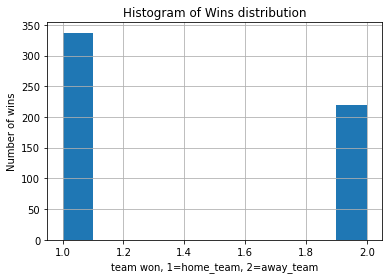

In [50]:
df_merged.result.hist()
plt.title("Histogram of Wins distribution")
plt.xlabel("team won, 1=home_team, 2=away_team")
plt.ylabel("Number of wins")
plt.plot()

We see that the home_team has more number of wins compared to away_team. 

There is class imbalance in the data. 

To handle this class imbalance we will upsample the away_team wins (result=2) class

In [51]:
# Upsampling the result=2 class

df_neg_new = df_neg.sample(len(df_pos), replace=True)

# merge the two dataframes to obtain the final dataset for training with balanced classes

df_merged = pd.concat([df_pos, df_neg_new], ignore_index=True)

[]

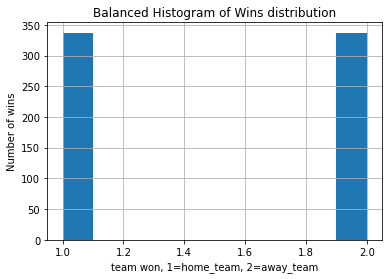

In [52]:
df_merged.result.hist()
plt.title("Balanced Histogram of Wins distribution")
plt.xlabel("team won, 1=home_team, 2=away_team")
plt.ylabel("Number of wins")
plt.plot()

In [53]:
df_merged

,index,result,att_1,mid_1,ovr_1,att_2,mid_2,ovr_2,overall_1,age_1,mentality_aggression_1,mentality_interceptions_1,mentality_positioning_1,mentality_vision_1,mentality_penalties_1,overall_2,age_2,mentality_aggression_2,mentality_interceptions_2,mentality_positioning_2,mentality_vision_2,mentality_penalties_2
0,2,1,75.75,75.0,75.0,74.0,74.0,74.0,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
1,4,1,76.00,76.0,76.0,76.0,70.0,73.0,76.130435,28.478261,64.434783,48.043478,63.608696,65.217391,64.304348,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
2,5,1,75.00,72.0,74.0,76.0,70.0,73.0,74.739130,26.956522,62.347826,57.304348,55.869565,56.913043,54.130435,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
3,9,1,76.00,77.0,75.0,74.0,74.0,74.0,72.695652,25.434783,47.217391,46.521739,65.391304,65.000000,53.869565,66.913043,25.695652,61.913043,50.739130,55.565217,58.608696,54.043478
4,10,1,80.00,84.0,83.0,74.0,74.0,74.0,84.086957,27.826087,60.304348,54.782609,67.739130,72.000000,65.130435,70.565217,28.043478,56.869565,55.521739,45.478261,49.391304,45.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,38,2,76.00,82.0,78.0,85.0,83.0,83.0,77.608696,27.260870,63.043478,57.782609,59.043478,68.217391,53.826087,82.347826,28.260870,61.173913,51.565217,64.695652,70.869565,62.565217
670,20,2,81.00,81.0,81.0,82.0,81.0,83.0,80.521739,26.826087,57.347826,48.478261,57.608696,67.652174,56.521739,83.347826,29.130435,58.347826,51.043478,43.608696,65.086957,51.173913
671,77,2,75.75,75.0,75.0,80.0,82.0,80.0,75.608696,27.304348,61.173913,56.826087,53.826087,60.043478,47.130435,79.217391,26.391304,64.434783,50.391304,67.043478,70.521739,66.739130
672,56,2,74.00,74.0,74.0,75.0,77.0,76.0,75.478261,28.652174,66.304348,53.391304,53.695652,63.739130,56.217391,78.608696,26.130435,70.434783,51.521739,66.173913,65.478261,65.173913


Now we obtain the X - traing dataframe, y - labels

In [54]:
X, y = df_merged.loc[:, df_merged.columns != 'result'], df_merged['result'].values

In [55]:
y=y.astype('int')

In [56]:
X = X.drop(['index'],axis=1)
X

,att_1,mid_1,ovr_1,att_2,mid_2,ovr_2,overall_1,age_1,mentality_aggression_1,mentality_interceptions_1,mentality_positioning_1,mentality_vision_1,mentality_penalties_1,overall_2,age_2,mentality_aggression_2,mentality_interceptions_2,mentality_positioning_2,mentality_vision_2,mentality_penalties_2
0,75.75,75.0,75.0,74.0,74.0,74.0,72.652174,24.652174,71.739130,58.826087,63.695652,65.521739,56.695652,72.739130,25.739130,64.304348,54.304348,60.913043,62.695652,58.869565
1,76.00,76.0,76.0,76.0,70.0,73.0,76.130435,28.478261,64.434783,48.043478,63.608696,65.217391,64.304348,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
2,75.00,72.0,74.0,76.0,70.0,73.0,74.739130,26.956522,62.347826,57.304348,55.869565,56.913043,54.130435,75.000000,29.043478,63.826087,52.043478,60.913043,61.000000,59.782609
3,76.00,77.0,75.0,74.0,74.0,74.0,72.695652,25.434783,47.217391,46.521739,65.391304,65.000000,53.869565,66.913043,25.695652,61.913043,50.739130,55.565217,58.608696,54.043478
4,80.00,84.0,83.0,74.0,74.0,74.0,84.086957,27.826087,60.304348,54.782609,67.739130,72.000000,65.130435,70.565217,28.043478,56.869565,55.521739,45.478261,49.391304,45.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,76.00,82.0,78.0,85.0,83.0,83.0,77.608696,27.260870,63.043478,57.782609,59.043478,68.217391,53.826087,82.347826,28.260870,61.173913,51.565217,64.695652,70.869565,62.565217
670,81.00,81.0,81.0,82.0,81.0,83.0,80.521739,26.826087,57.347826,48.478261,57.608696,67.652174,56.521739,83.347826,29.130435,58.347826,51.043478,43.608696,65.086957,51.173913
671,75.75,75.0,75.0,80.0,82.0,80.0,75.608696,27.304348,61.173913,56.826087,53.826087,60.043478,47.130435,79.217391,26.391304,64.434783,50.391304,67.043478,70.521739,66.739130
672,74.00,74.0,74.0,75.0,77.0,76.0,75.478261,28.652174,66.304348,53.391304,53.695652,63.739130,56.217391,78.608696,26.130435,70.434783,51.521739,66.173913,65.478261,65.173913


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Training classification models

First, we train a K nearest neighbors classifer with default parameters. 


### KNN Classifier and tuning

In [58]:
base_knn = KNeighborsClassifier()

base_knn.fit(X_train, y_train)

print("Accuracy for knn using default hyperparameters \n", 
      accuracy_score(y_test, base_knn.predict(X_test)))


Accuracy for knn using default hyperparameters 
 0.7058823529411765


Now, we find the best parameters using hyperparamter tuning from the given grid

In [59]:
parameters_KNN = {
    'n_neighbors': (2, 5, 7, 10, 12),
    'leaf_size': (1, 5,10,15,20,30,40),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}

estimator_KNN = KNeighborsClassifier()

grid = GridSearchCV(estimator = estimator_KNN, param_grid=parameters_KNN, cv = 5, verbose=2, n_jobs = -1)

grid.fit(X_train, y_train)

best_knn = grid.best_estimator_

print("base model params", base_knn.get_params())
print("best model params", best_knn.get_params())

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
base model params {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
best model params {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'chebyshev', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [60]:
base_knn.fit(X_train, y_train)

base_y_pred = base_knn.predict(X_test)
print("base model accuracy", accuracy_score(y_test, base_y_pred))


best_y_pred = best_knn.predict(X_test)
print("knn best model accuracy", accuracy_score(y_test, best_y_pred))


base model accuracy 0.7058823529411765
knn best model accuracy 0.7647058823529411


In [61]:
base_knn_report = classification_report(y_test, base_y_pred)
print("base knn performance", base_knn_report)

best_knn_report = classification_report(y_test, best_y_pred)
print("base knn performance", best_knn_report)

base knn performance               precision    recall  f1-score   support

           1       0.71      0.71      0.71        34
           2       0.71      0.71      0.71        34

    accuracy                           0.71        68
   macro avg       0.71      0.71      0.71        68
weighted avg       0.71      0.71      0.71        68

base knn performance               precision    recall  f1-score   support

           1       0.85      0.65      0.73        34
           2       0.71      0.88      0.79        34

    accuracy                           0.76        68
   macro avg       0.78      0.76      0.76        68
weighted avg       0.78      0.76      0.76        68



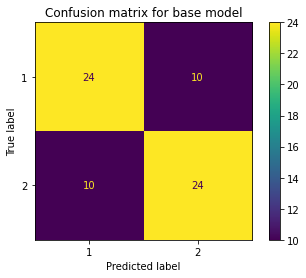

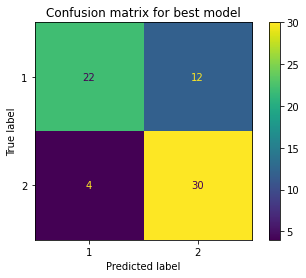

In [62]:
cm = confusion_matrix(y_test, base_y_pred, labels=base_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_knn.classes_)

disp.plot()
plt.title("Confusion matrix for base model")
plt.show()


cm = confusion_matrix(y_test, best_y_pred, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_knn.classes_)

disp.plot()
plt.title("Confusion matrix for best model")
plt.show()

### Support vector classifier and tuning

In [63]:
# base classifier with default parameters
base_svc = SVC()
base_svc.fit(X_train, y_train)
print("base SVC accuracy", accuracy_score(y_test, base_svc.predict(X_test)))

base SVC accuracy 0.6617647058823529


In [64]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

best_svc = grid.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 3/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 4/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 5/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 1/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ...................C=0.1, gamma=0.

[CV 3/5] END ......................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV 4/5] END ......................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV 5/5] END ......................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV 1/5] END ..................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 2/5] END ..................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 3/5] END ..................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 4/5] END ..................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 5/5] END ..................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV 1/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C=1000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV 2/5] END ..............C=1000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV 3/5] END ..............C=1000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV 4/5] END ..............C=1000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV 5/5] END ..............C=1000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV 1/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END ...............

In [65]:
base_svc.fit(X_train, y_train)

base_y_pred = base_svc.predict(X_test)
print("base svc model accuracy", accuracy_score(y_test, base_y_pred))


best_y_pred = best_svc.predict(X_test)
print("svc best model accuracy", accuracy_score(y_test, best_y_pred))


base svc model accuracy 0.6617647058823529
svc best model accuracy 0.8970588235294118


In [66]:
base_svc_report = classification_report(y_test, base_y_pred)
print("base svc performance", base_svc_report)

best_svc_report = classification_report(y_test, best_y_pred)
print("best svc performance", best_svc_report)

base svc performance               precision    recall  f1-score   support

           1       0.67      0.65      0.66        34
           2       0.66      0.68      0.67        34

    accuracy                           0.66        68
   macro avg       0.66      0.66      0.66        68
weighted avg       0.66      0.66      0.66        68

best svc performance               precision    recall  f1-score   support

           1       0.83      1.00      0.91        34
           2       1.00      0.79      0.89        34

    accuracy                           0.90        68
   macro avg       0.91      0.90      0.90        68
weighted avg       0.91      0.90      0.90        68



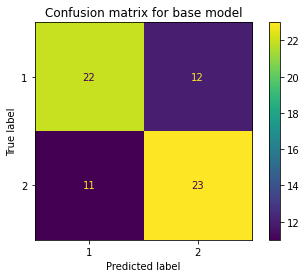

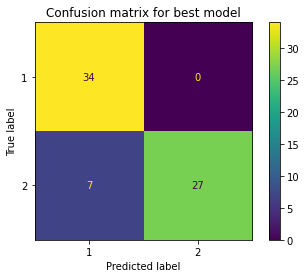

In [67]:
cm = confusion_matrix(y_test, base_y_pred, labels=base_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_svc.classes_)

disp.plot()
plt.title("Confusion matrix for base model")
plt.show()


cm = confusion_matrix(y_test, best_y_pred, labels=best_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svc.classes_)

disp.plot()
plt.title("Confusion matrix for best model")

plt.show()

### Random Forest Classifier and Tuning

In [68]:
base_rfc = RandomForestClassifier()
base_rfc.fit(X_train, y_train)


accuracy_score(y_test, base_rfc.predict(X_test))

0.7941176470588235

Hyperparameter Tuning the RF classifier

In [69]:
# Number of trees in random forest
n_estimators=[50, 100, 150]
# Number of features to consider at every split
max_features = ['auto']

# Minimum number of samples required to split a node
min_samples_split = [1,2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

criterion=['gini', 'entropy', 'log_loss']

# ccp_alpha=[int(x) for x in np.arange(start = 0, stop = 100, step = 15)]
ccp_alpha=[0.0 , 0.1, 0.001, 0.0001]

# Create the random grid
grid = {'n_estimators': n_estimators,
            'criterion':criterion,
        'ccp_alpha':ccp_alpha,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
       }
print(grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_grid = GridSearchCV(estimator = base_rfc, param_grid=grid, cv = 5, verbose=3, n_jobs = -1)

# Fit the random search model and get the best estimator
rf_grid.fit(X_train, y_train)
best_rfc = rf_grid.best_estimator_

{'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy', 'log_loss'], 'ccp_alpha': [0.0, 0.1, 0.001, 0.0001], 'max_features': ['auto'], 'min_samples_split': [1, 2, 5], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [70]:
base_y_pred = base_rfc.predict(X_test)
print("base rfc model accuracy", accuracy_score(y_test, base_y_pred))

best_y_pred = best_rfc.predict(X_test)
print("best rfc model accuracy", accuracy_score(y_test, best_y_pred))

print(base_rfc.get_params())
print(best_rfc.get_params())

base rfc model accuracy 0.7941176470588235
best rfc model accuracy 0.7941176470588235
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [71]:
base_rfc_report = classification_report(y_test, base_y_pred)
print("base rfc performance", base_rfc_report)

best_rfc_report = classification_report(y_test, best_y_pred)
print("best rfc performance", best_rfc_report)

base rfc performance               precision    recall  f1-score   support

           1       0.83      0.74      0.78        34
           2       0.76      0.85      0.81        34

    accuracy                           0.79        68
   macro avg       0.80      0.79      0.79        68
weighted avg       0.80      0.79      0.79        68

best rfc performance               precision    recall  f1-score   support

           1       0.83      0.74      0.78        34
           2       0.76      0.85      0.81        34

    accuracy                           0.79        68
   macro avg       0.80      0.79      0.79        68
weighted avg       0.80      0.79      0.79        68



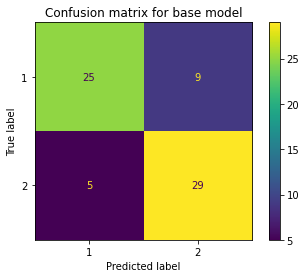

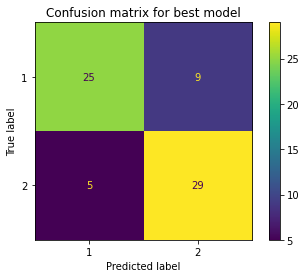

In [72]:
cm = confusion_matrix(y_test, base_y_pred, labels=base_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_rfc.classes_)

disp.plot()
plt.title("Confusion matrix for base model")
plt.show()


cm = confusion_matrix(y_test, best_y_pred, labels=best_rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rfc.classes_)

disp.plot()
plt.title("Confusion matrix for best model")
plt.show()

Plotting the important feature according random forest best model

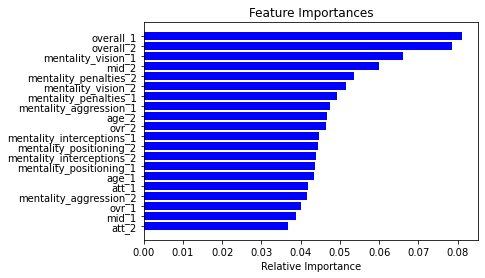

In [73]:
features = X_train.columns
importances = base_rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, we ensemble the above 3 classifiers using voting classifier to obtain best of all worlds

In [74]:
estimator = []

estimator.append(('KNN', best_knn))
estimator.append(('RFC', best_rfc))
estimator.append(('SVC', best_svc))
  

voting_classifier = VotingClassifier(estimators = estimator)
voting_classifier.fit(X_train, y_train)

ens_pred = voting_classifier.predict(X_test)
print('ensemble classifie accuracy', accuracy_score(y_test, ens_pred))

ensemble classifie accuracy 0.7941176470588235


We have better accuracy than indivudual models.

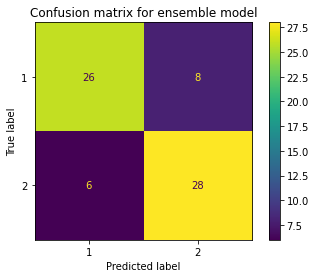

In [75]:
cm = confusion_matrix(y_test, ens_pred, labels=voting_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_classifier.classes_)

disp.plot()
plt.title("Confusion matrix for ensemble model")
plt.show()

## Fifa 2022 world cup simulations

Here we simulate a match between two teams based on the given input that predicts which of the either team is going to win.

These simulations are done only on the simulate 2022 dataframe.

Given team1 and team2 we obtian the input for the model and predict thr winner/

In [76]:
def match(wc, team1, team2, model):
    
    # create an empty match dataframe 
    match = pd.DataFrame(columns=['att_1','mid_1','ovr_1', 'att_2', 'mid_2', 'ovr_2', 'overall_1', 'age_1', 
                                  'mentality_aggression_1',
                                  'mentality_interceptions_1', 'mentality_positioning_1',
                                  'mentality_vision_1', 'mentality_penalties_1', 'overall_2'
                                  'age_2', 'mentality_aggression_2', 'mentality_interceptions_2', 
                                  'mentality_positioning_2','mentality_vision_2','mentality_penalties_2'], index=[0])
    
    
    # fill all atrributes in the dataframe from the simluate 2022 world cup dataframe
    match['att_1'] = wc[wc.nationality_name == team1]['att'].iloc[0]
    match['mid_1'] = wc[wc.nationality_name == team1]['mid'].iloc[0]
    match['ovr_1'] = wc[wc.nationality_name == team1]['ovr'].iloc[0]
    match['att_2'] = wc[wc.nationality_name == team2]['att'].iloc[0]
    match['mid_2'] = wc[wc.nationality_name == team2]['mid'].iloc[0]
    match['ovr_2'] = wc[wc.nationality_name == team2]['ovr'].iloc[0]
    match['mentality_aggression_1'] = wc[wc.nationality_name == team1]['mentality_aggression'].iloc[0]
    match['mentality_interceptions_1'] = wc[wc.nationality_name == team1]['mentality_interceptions'].iloc[0]
    match['mentality_vision_1'] = wc[wc.nationality_name == team1]['mentality_vision'].iloc[0]
    match['mentality_positioning_1'] = wc[wc.nationality_name == team1]['mentality_positioning'].iloc[0]
    match['mentality_penalties_1'] = wc[wc.nationality_name == team1]['mentality_penalties'].iloc[0]
    match['overall_1'] = wc[wc.nationality_name == team1]['overall'].iloc[0]
    match['age_1'] = wc[wc.nationality_name == team1]['age'].iloc[0]
    match['mentality_aggression_2'] = wc[wc.nationality_name == team2]['mentality_aggression'].iloc[0]
    match['mentality_interceptions_2'] = wc[wc.nationality_name == team2]['mentality_interceptions'].iloc[0]
    match['mentality_vision_2'] = wc[wc.nationality_name == team2]['mentality_vision'].iloc[0]
    match['mentality_positioning_2'] = wc[wc.nationality_name == team2]['mentality_positioning'].iloc[0]
    match['mentality_penalties_2'] = wc[wc.nationality_name == team2]['mentality_penalties'].iloc[0]
    match['overall_2'] = wc[wc.nationality_name == team2]['overall'].iloc[0]
    match['age_2'] = wc[wc.nationality_name == team2]['age'].iloc[0]
    
    
    match = match[['att_1','mid_1','ovr_1',\
                   'att_2','mid_2','ovr_2',\
                   'overall_1','age_1','mentality_aggression_1',\
                   'mentality_interceptions_1','mentality_positioning_1',\
                   'mentality_vision_1','mentality_penalties_1','overall_2',\
                   'age_2','mentality_aggression_2','mentality_interceptions_2',\
                   'mentality_positioning_2','mentality_vision_2','mentality_penalties_2']]
    
    
    match_array = match.values
    prediction = model.predict(match_array)
    
    winner = None
    
    if prediction == 1:
        winner = team1
    elif prediction == 2:
        winner = team2
    
    return winner

In [77]:
match(simulate2022_modified, 'Brazil', 'Spain', voting_classifier)

'Brazil'

## Adding Randomness

To get better estimate for match winner we run this model prediction **N** times.

We add a random value for each country.

In [78]:
simulate2022_modified.std()

overall                    4.447787
age                        1.269570
mentality_aggression       4.910491
mentality_interceptions    5.262880
mentality_positioning      5.273459
mentality_vision           4.904951
mentality_penalties        4.484919
att                        4.280442
mid                        4.029616
def                        4.229686
ovr                        4.193927
dtype: float64

In [79]:
def match(wc, team1, team2, model, random_scale = 2):
    
    match = pd.DataFrame(columns=['att_1','mid_1', 'ovr_1', 'att_2', 'mid_2', 'ovr_2', 'overall_1', 'age_1', 
                                  'mentality_aggression_1',
                                  'mentality_interceptions_1', 'mentality_positioning_1',
                                  'mentality_vision_1', 'mentality_penalties_1', 'overall_2'
                                  'age_2', 'mentality_aggression_2', 'mentality_interceptions_2', 
                                  'mentality_positioning_2','mentality_vision_2','mentality_penalties_2'], index=[0])
    
    att_1= wc[wc.nationality_name == team1]['att'].iloc[0]
    mid_1 = wc[wc.nationality_name == team1]['mid'].iloc[0]
    ovr_1 = wc[wc.nationality_name == team1]['ovr'].iloc[0]
    overall_1 = wc[wc.nationality_name == team1]['overall'].iloc[0]
    age_1 = wc[wc.nationality_name == team1]['age'].iloc[0]
    mentality_aggression_1 = wc[wc.nationality_name == team1]['mentality_aggression'].iloc[0]
    mentality_interceptions_1= wc[wc.nationality_name == team1]['mentality_interceptions'].iloc[0]
    mentality_vision_1 = wc[wc.nationality_name == team1]['mentality_vision'].iloc[0]
    mentality_positioning_1 = wc[wc.nationality_name == team1]['mentality_positioning'].iloc[0]
    mentality_penalties_1 = wc[wc.nationality_name == team1]['mentality_penalties'].iloc[0]
    att_2 = wc[wc.nationality_name == team2]['att'].iloc[0]
    mid_2 = wc[wc.nationality_name == team2]['mid'].iloc[0]
    ovr_2 = wc[wc.nationality_name == team2]['ovr'].iloc[0]
    overall_2 = wc[wc.nationality_name == team2]['overall'].iloc[0]
    age_2 = wc[wc.nationality_name == team2]['age'].iloc[0]
    mentality_aggression_2 = wc[wc.nationality_name == team2]['mentality_aggression'].iloc[0]
    mentality_interceptions_2 = wc[wc.nationality_name == team2]['mentality_interceptions'].iloc[0]
    mentality_vision_2 = wc[wc.nationality_name == team2]['mentality_vision'].iloc[0]
    mentality_positioning_2 = wc[wc.nationality_name == team2]['mentality_positioning'].iloc[0]
    mentality_penalties_2 = wc[wc.nationality_name == team2]['mentality_penalties'].iloc[0]
 
    # add randomness for country 1
    match['att_1'] = np.random.normal(att_1, random_scale)
    match['mid_1'] = np.random.normal(mid_1, random_scale)
    match['ovr_1'] = np.random.normal(ovr_1, random_scale)
    match['overall_1'] = np.random.normal(overall_1, random_scale)      
    match['age_1'] = np.random.normal(age_1, random_scale)
    match['mentality_aggression_1'] = np.random.normal(mentality_aggression_1, random_scale)
    match['mentality_interceptions_1'] = np.random.normal(mentality_interceptions_1, random_scale)
    match['mentality_vision_1'] = np.random.normal(mentality_vision_1, random_scale)      
    match['mentality_positioning_1'] = np.random.normal(mentality_positioning_1, random_scale)
    match['mentality_penalties_1'] = np.random.normal(mentality_penalties_1, random_scale)
    
    # add randomness for country 2
    match['att_2'] = np.random.normal(att_2, random_scale)      
    match['mid_2'] = np.random.normal(mid_2, random_scale)
    match['ovr_2'] = np.random.normal(ovr_2, random_scale)
    match['overall_2'] = np.random.normal(overall_2, random_scale)      
    match['age_2'] = np.random.normal(age_2, random_scale)
    match['mentality_aggression_2'] = np.random.normal(mentality_aggression_2, random_scale)
    match['mentality_interceptions_2'] = np.random.normal(mentality_interceptions_2, random_scale)
    match['mentality_vision_2'] = np.random.normal(mentality_vision_2, random_scale)      
    match['mentality_positioning_2'] = np.random.normal(mentality_positioning_2, random_scale)
    match['mentality_penalties_2'] = np.random.normal(mentality_penalties_2, random_scale)
    
    # reconstruct the match array for prediction
    match = match[['att_1','mid_1','ovr_1','att_2','mid_2','ovr_2',\
                    'overall_1','age_1','mentality_aggression_1','mentality_interceptions_1',\
                    'mentality_positioning_1','mentality_vision_1','mentality_penalties_1',\
                    'overall_2','age_2','mentality_aggression_2','mentality_interceptions_2',\
                    'mentality_positioning_2','mentality_vision_2','mentality_penalties_2']]
    
    match_array = match.values
    prediction = model.predict(match_array)
    
    winner = None
    
    if prediction == 1:
        winner = team1
    elif prediction == 2:
        winner = team2
    
    return winner

In [80]:
winner = match(simulate2022_modified, 'Brazil','Spain', voting_classifier)
winner

'Brazil'

### Now, we run the simulation for given n number of times to obtain % of matches where each team wins

In [81]:
def simulate(team1, team2, model, simulate_df, random_scale = 2, n_matches=10000):
    
    match_results = []
    
    # run the loop for given number of matches
    for i in range(n_matches):
        match_results.append(match(simulate_df, team1, team2, model, random_scale = random_scale))
        
    # count the match winners
    team1_proba = match_results.count(team1)/len(match_results)*100
    team2_proba = match_results.count(team2)/len(match_results)*100
    
    print(team1, str(round(team1_proba, 2)) + '%')
    print(team2, str(round(team2_proba, 2)) + '%')
    
    if team1_proba > team2_proba:
        overall_winner = team1
    else:
        overall_winner = team2
    
    return {'team1': team1,
            'team2': team2,
            'team1_proba': round(team1_proba, 2), 
            'team2_proba': round(team2_proba, 2), 
            'overall_winner': overall_winner,
            'match_results': match_results}

### Run the simulation n times and get the overall winner


Also calculate the divergence of the predictions as we progress through simulations.

In [82]:
def get_divergence(simulation_results):
    p_list = []
    for i in range(len(simulation_results['match_results'])):
        country_1 = simulation_results['team1']
        country_2 = simulation_results['team2'] 
        
        # count team 1 wins as we progress through iterations
        cnt1 = simulation_results['match_results'][:i].count(country_1) / (i+1) * 100
        
        # count team 2 wins as we progress through iterations
        cnt2 = simulation_results['match_results'][:i].count(country_2) / (i+1) * 100
        
        # save the difference in counts of the team1 - team2
        p_list.append(cnt1 - cnt2)
        
    return p_list

France 94.5%
England 5.5%
overall winner is France


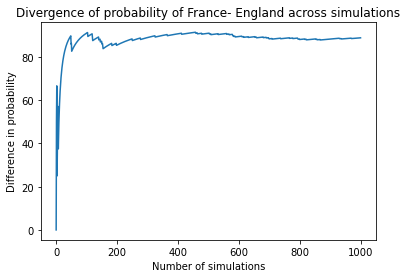

In [83]:
simulation_results = simulate('France', 'England', voting_classifier, simulate2022_modified, n_matches=1000)
print("overall winner is", simulation_results['overall_winner'])

p_list = get_divergence(simulation_results)
plt.plot(p_list)
plt.title(f"Divergence of probability of {simulation_results['team1']}- {simulation_results['team2']} across simulations")
plt.xlabel("Number of simulations")
plt.ylabel("Difference in probability")
plt.show()

## We are all set for Worldcup 2022. Let's GO!

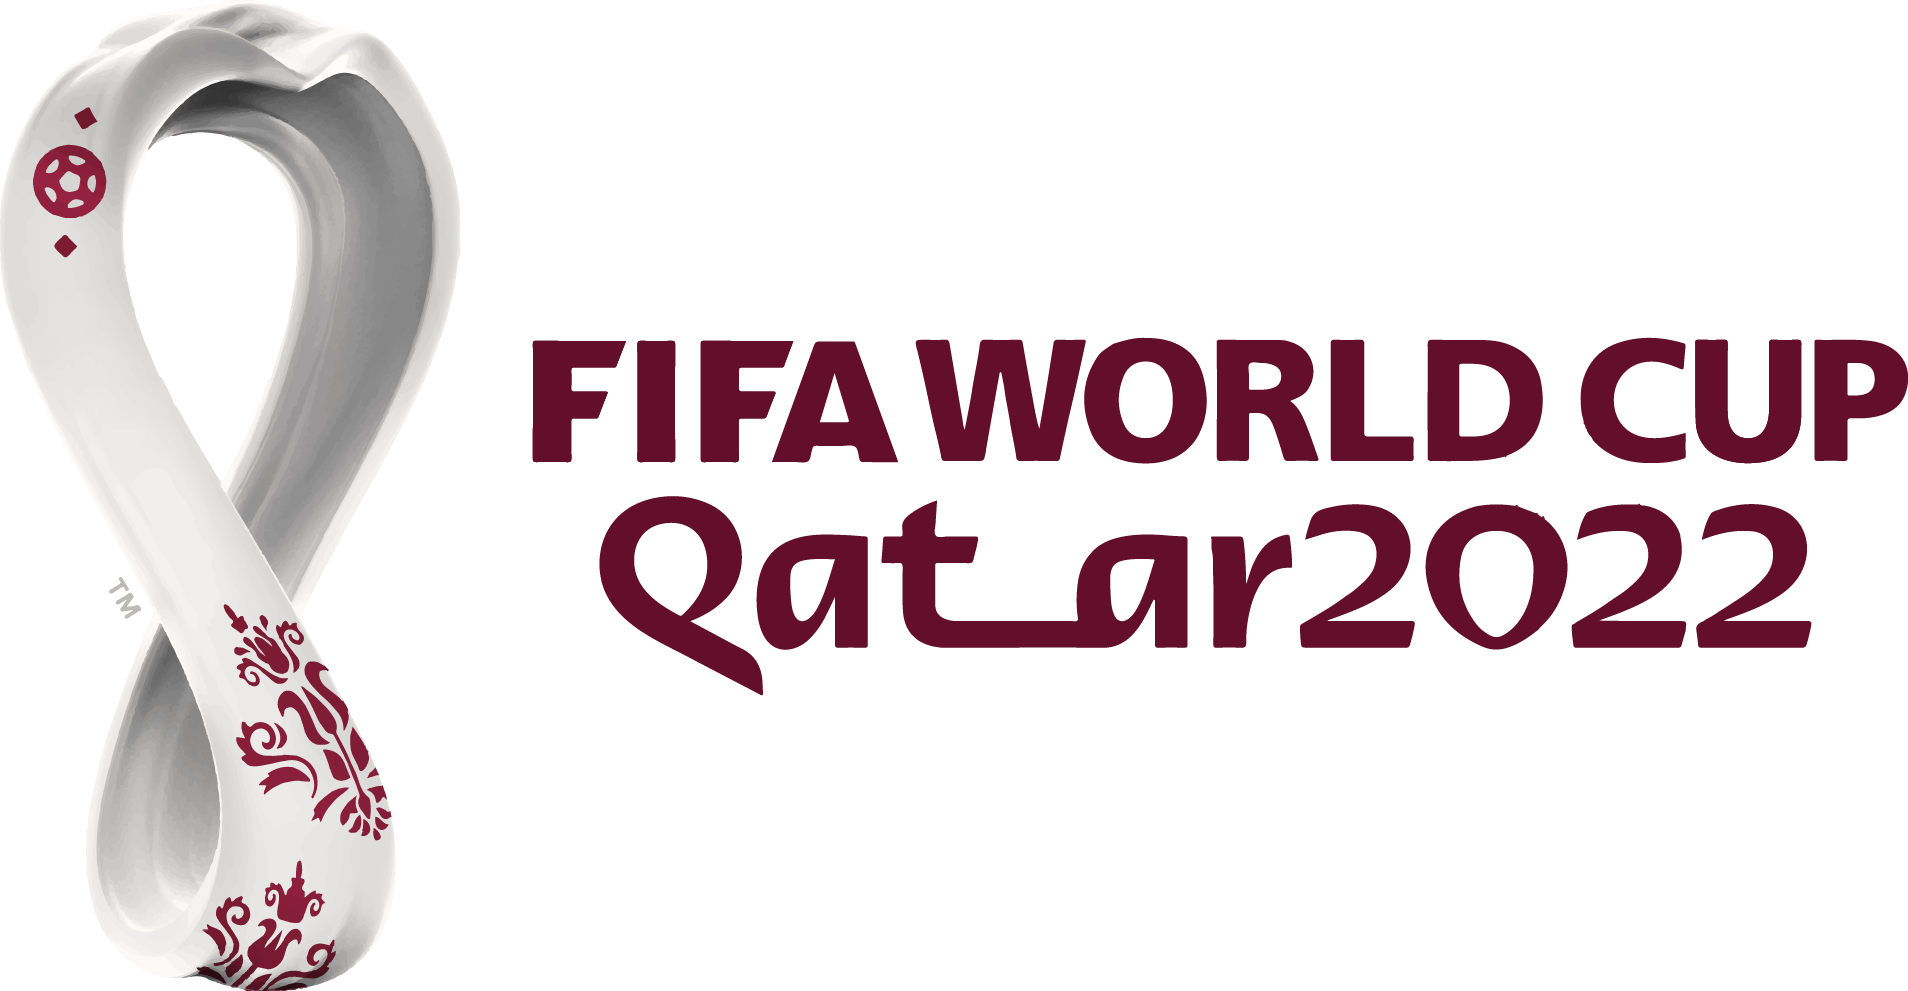

### GROUP A

In [84]:
group_a = ['Netherlands', 'Senegal', 'Ecuador']

mats = combinations(group_a, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified, random_scale=5, n_matches=1000)
    print('-------')

match between ('Netherlands', 'Senegal')
Netherlands 98.3%
Senegal 1.7%
-------
match between ('Netherlands', 'Ecuador')
Netherlands 99.1%
Ecuador 0.9%
-------
match between ('Senegal', 'Ecuador')
Senegal 81.1%
Ecuador 18.9%
-------


#### From  Group A Senegal and Netherlands are going to Round of 16. Netherlands is group winner and Senegal as group runner up

### Group B

In [85]:
group_b = ['United States', 'Iran','England', 'Wales']

mats = combinations(group_b, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('United States', 'Iran')
United States 76.3%
Iran 23.7%
-------
match between ('United States', 'England')
United States 11.2%
England 88.8%
-------
match between ('United States', 'Wales')
United States 87.3%
Wales 12.7%
-------
match between ('Iran', 'England')
Iran 11.0%
England 89.0%
-------
match between ('Iran', 'Wales')
Iran 79.3%
Wales 20.7%
-------
match between ('England', 'Wales')
England 99.9%
Wales 0.1%
-------


### England is going to enter round of 16 as Group B winner where as United States as Group runner up

### Group C

In [86]:
group_c = ['Poland', 'Mexico', 'Saudi Arabia', 'Argentina']

mats = combinations(group_c, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier, simulate2022_modified, random_scale=5, n_matches=1000)
    print('-------')

match between ('Poland', 'Mexico')
Poland 70.1%
Mexico 29.9%
-------
match between ('Poland', 'Saudi Arabia')
Poland 90.5%
Saudi Arabia 9.5%
-------
match between ('Poland', 'Argentina')
Poland 17.5%
Argentina 82.5%
-------
match between ('Mexico', 'Saudi Arabia')
Mexico 94.8%
Saudi Arabia 5.2%
-------
match between ('Mexico', 'Argentina')
Mexico 25.0%
Argentina 75.0%
-------
match between ('Saudi Arabia', 'Argentina')
Saudi Arabia 9.6%
Argentina 90.4%
-------


### Argentina is going to enter  round of 16 as Group C winner where  as Poland as Group runner up

Poland 70.1%
Mexico 29.9%
overall winner is Poland


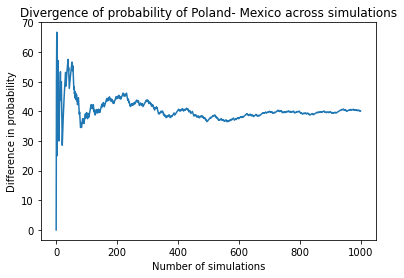

In [87]:
simulation_results = simulate('Poland', 'Mexico', voting_classifier, simulate2022_modified,  random_scale=5, n_matches=1000)
print("overall winner is", simulation_results['overall_winner'])

p_list = get_divergence(simulation_results)
plt.plot(p_list)
plt.title(f"Divergence of probability of {simulation_results['team1']}- {simulation_results['team2']} across simulations")
plt.xlabel("Number of simulations")
plt.ylabel("Difference in probability")
plt.show()

### Group D

In [88]:
group_d = ['Australia', 'France', 'Tunisia', 'Denmark']

mats = combinations(group_d, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('Australia', 'France')
Australia 5.4%
France 94.6%
-------
match between ('Australia', 'Tunisia')
Australia 76.3%
Tunisia 23.7%
-------
match between ('Australia', 'Denmark')
Australia 55.0%
Denmark 45.0%
-------
match between ('France', 'Tunisia')
France 99.7%
Tunisia 0.3%
-------
match between ('France', 'Denmark')
France 99.5%
Denmark 0.5%
-------
match between ('Tunisia', 'Denmark')
Tunisia 54.7%
Denmark 45.3%
-------


#### France is going to enter  round of 16 as Group D winner where  as Australia as Group runner up

### Group E

In [89]:
group_e = ['Japan', 'Costa Rica', 'Spain', 'Germany']

mats = combinations(group_e, 2)


for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('Japan', 'Costa Rica')
Japan 99.7%
Costa Rica 0.3%
-------
match between ('Japan', 'Spain')
Japan 28.0%
Spain 72.0%
-------
match between ('Japan', 'Germany')
Japan 12.5%
Germany 87.5%
-------
match between ('Costa Rica', 'Spain')
Costa Rica 9.0%
Spain 91.0%
-------
match between ('Costa Rica', 'Germany')
Costa Rica 3.3%
Germany 96.7%
-------
match between ('Spain', 'Germany')
Spain 44.4%
Germany 55.6%
-------


#### Spain is going to enter  round of 16 as Group E winner where  as Germany as Group runner up

Note: Actually, Japan and Spain came out of the group. WC match b/w Germany and Spain was a draw. 

### Group F

In [90]:
group_f = ['Morocco', 'Croatia', 'Canada', 'Belgium']

mats = combinations(group_f, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('Morocco', 'Croatia')
Morocco 42.0%
Croatia 58.0%
-------
match between ('Morocco', 'Canada')
Morocco 92.4%
Canada 7.6%
-------
match between ('Morocco', 'Belgium')
Morocco 41.0%
Belgium 59.0%
-------
match between ('Croatia', 'Canada')
Croatia 97.7%
Canada 2.3%
-------
match between ('Croatia', 'Belgium')
Croatia 60.4%
Belgium 39.6%
-------
match between ('Canada', 'Belgium')
Canada 20.1%
Belgium 79.9%
-------


#### Croatia is going to enter round of 16 as Group F winner where  as Belgium as Group runner up.

Note: Actually, Morocco and Croatia came out of the group.

### Group G

In [91]:
group_g = ['Switzerland', 'Cameroon', 'Brazil', 'Serbia']


mats = combinations(group_g, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('Switzerland', 'Cameroon')
Switzerland 88.7%
Cameroon 11.3%
-------
match between ('Switzerland', 'Brazil')
Switzerland 42.0%
Brazil 58.0%
-------
match between ('Switzerland', 'Serbia')
Switzerland 88.2%
Serbia 11.8%
-------
match between ('Cameroon', 'Brazil')
Cameroon 30.5%
Brazil 69.5%
-------
match between ('Cameroon', 'Serbia')
Cameroon 65.0%
Serbia 35.0%
-------
match between ('Brazil', 'Serbia')
Brazil 97.3%
Serbia 2.7%
-------


#### Brazil is going to enter the Round of 16 as  group G winner and Switzerland  as Runner up.

### Group H

In [92]:
group_h = ['Portugal', 'Uruguay', 'Ghana']

mats = combinations(group_h, 2)

for m in mats:
    print('match between', m)
    simulate(m[0],m[1], voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)
    print('-------')

match between ('Portugal', 'Uruguay')
Portugal 98.2%
Uruguay 1.8%
-------
match between ('Portugal', 'Ghana')
Portugal 99.8%
Ghana 0.2%
-------
match between ('Uruguay', 'Ghana')
Uruguay 95.8%
Ghana 4.2%
-------


#### Portugal  is going to enter the Round of 16 as group G winner and Uruguay as Runner up.

We predicted 14/16 countries accurately at their exact spot from group matches to Round of 16.

## Round of 16

### We will simulate the Round of 16 according to our group predictions

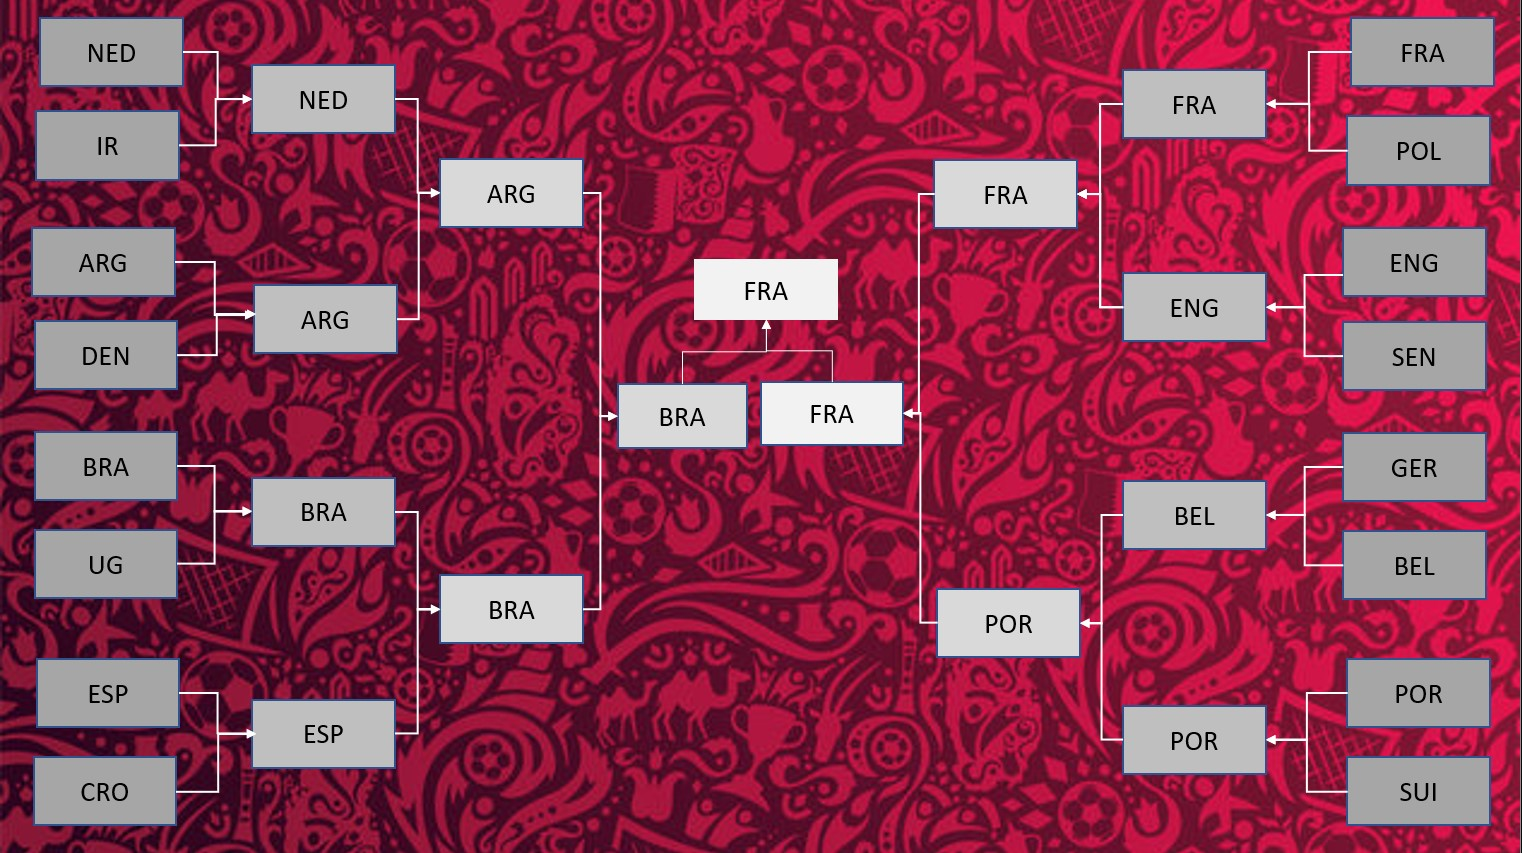

#### First Match

In [93]:
result = simulate('Netherlands', 'United States', voting_classifier,simulate2022_modified,  random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

Netherlands 98.6%
United States 1.4%
winner:  Netherlands


#### Second Match

In [94]:
result = simulate('England', 'Senegal',voting_classifier, simulate2022_modified,  random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

England 99.3%
Senegal 0.7%
winner:  England


#### Third Match

In [95]:
result = simulate('Argentina', 'Australia',voting_classifier, simulate2022_modified,  random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

Argentina 100.0%
Australia 0.0%
winner:  Argentina


#### Fourth Match

In [96]:
result = simulate('France', 'Poland',voting_classifier,simulate2022_modified, random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

France 99.2%
Poland 0.8%
winner:  France


#### Fifth Match

In [114]:
result = simulate('Croatia', 'Germany',voting_classifier, simulate2022_modified,  
random_scale=10, n_matches=1000)

print("winner: ", result['overall_winner'])

Croatia 62.5%
Germany 37.5%
winner:  Croatia


#### Sixth Match

In [98]:
result = simulate('Belgium', 'Spain',voting_classifier, simulate2022_modified, random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

Belgium 73.3%
Spain 26.7%
winner:  Belgium


#### Seventh Match

In [99]:
result = simulate('Brazil', 'Uruguay',voting_classifier,simulate2022_modified, random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

Brazil 96.6%
Uruguay 3.4%
winner:  Brazil


#### Eighth Match

In [100]:
result = simulate('Portugal','Switzerland',voting_classifier,simulate2022_modified, random_scale=5, n_matches=1000)

print("winner: ", result['overall_winner'])

Portugal 98.2%
Switzerland 1.8%
winner:  Portugal


### Let's go to QuaterFinals

In [116]:
result = simulate('Argentina', 'Netherlands', voting_classifier, simulate2022_modified,
random_scale = 5, n_matches=1000)

print("winner: ", result['overall_winner'])

Argentina 88.6%
Netherlands 11.4%
winner:  Argentina


In [102]:
result = simulate('Brazil', 'Belgium', voting_classifier,simulate2022_modified, 
random_scale = 5, n_matches=1000)

print("winner: ", result['overall_winner'])

Brazil 82.0%
Belgium 18.0%
winner:  Brazil


In [103]:
result = simulate('France', 'England',voting_classifier, simulate2022_modified, 
random_scale = 5, n_matches=1000)

print("winner: ", result['overall_winner'])

France 86.9%
England 13.1%
winner:  France


In [118]:
result = simulate('Croatia', 'Portugal', voting_classifier, simulate2022_modified,
random_scale = 5, n_matches=1000)

print("winner: ", result['overall_winner'])

Croatia 55.9%
Portugal 44.1%
winner:  Croatia


### Semi-Finals

In [105]:
result = simulate('Argentina', 'Brazil', voting_classifier, simulate2022_modified, 
random_scale =5, n_matches=1000)

print("winner: ", result['overall_winner'])

Argentina 88.8%
Brazil 11.2%
winner:  Argentina


In [106]:
result = simulate('France', 'Croatia', voting_classifier, simulate2022_modified,
random_scale =5, n_matches=1000)

print("winner: ", result['overall_winner'])

France 95.0%
Croatia 5.0%
winner:  France


### Now, for the most awaited Final!

In [119]:
result = simulate('France', 'Argentina', voting_classifier, simulate2022_modified,
random_scale =5, n_matches=1000)

print("winner: ", result['overall_winner'])

France 88.1%
Argentina 11.9%
winner:  France


In [120]:
result = simulate('France', 'Argentina', voting_classifier, simulate2022_modified,
random_scale = 10, n_matches=1000)

print("winner: ", result['overall_winner'])

France 80.8%
Argentina 19.2%
winner:  France
